### Imports

In [65]:
import pandas as pd
from sklearn.utils import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score
from torchtext.data.utils import get_tokenizer
import numpy as np
from torchtext.vocab import GloVe, Vectors
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder


from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.saving import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping



### Read data, preprocessing, split

In [66]:
train_data = pd.read_csv("//kaggle/input/imdb-data/IMDB_Dataset.csv")
train_data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [67]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [68]:
# preprocessing
train_data = train_data.dropna()

In [69]:
# train test split
X_train, X_test, y_train, y_test =  train_test_split(train_data["review"], train_data["sentiment"], test_size=0.2, random_state=42)

In [70]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((40000,), (10000,), (40000,), (10000,))

In [71]:
all_categories = ["Negative", "Positive"]

### Use Glove for embedding 

In [72]:
glove = GloVe(name="6B", dim=100)

In [73]:
tokenizer = get_tokenizer("basic_english")
text = train_data["review"][1]
tokens = tokenizer(text)
print(text)
print(tokens)

A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surface) are terribly well done.
[

In [74]:
def new_embedding(tokens, max_length=200, embedding_dim=100):
    tokens_array = tokenizer(tokens)
    word_embedding = map(lambda x: glove[x], tokens_array[0:max_length])
    word_embedding = np.array(list(word_embedding))
    difference = max_length - len(tokens_array)
    difference = 0 if difference < 0 else difference
    result = np.concatenate((word_embedding, np.zeros((difference,embedding_dim))))
    return result
X = np.array(list(map(new_embedding, X_train)))


### Label Encoding

In [78]:
def encoding(y):
    le = LabelEncoder()
    y=le.fit_transform(y)
    return y

y = encoding(y_train)

In [79]:
X.shape, y.shape

((40000, 200, 100), (40000,))

### Build and fit model

In [80]:
max_length_model =  200
embedding_dim_model = 100

In [81]:
model = Sequential()
model.add(LSTM(256))
model.add(Dropout(0.1))
model.add(Dense(1, activation="sigmoid"))
model.build(input_shape=(1, max_length_model, embedding_dim_model))
model.compile(optimizer='nadam', loss='binary_crossentropy', metrics=["accuracy"])
print(model.summary())

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (1, 256)               │       365,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (1, 256)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (1, 1)                 │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 365,825 (1.40 MB)

 Trainable params: 365,825 (1.40 MB)

 Non-trainable params: 0 (0.00 B)

None


In [82]:
early_stopping = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=3,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0,
)
history=model.fit(X, y, epochs=30, batch_size=128, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.5401 - loss: 0.6872 - val_accuracy: 0.5994 - val_loss: 0.6640
Epoch 2/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.5677 - loss: 0.6785 - val_accuracy: 0.5606 - val_loss: 0.6766
Epoch 3/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.5924 - loss: 0.6673 - val_accuracy: 0.7879 - val_loss: 0.4774
Epoch 4/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.7965 - loss: 0.4473 - val_accuracy: 0.8273 - val_loss: 0.3872
Epoch 5/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.8322 - loss: 0.3758 - val_accuracy: 0.8425 - val_loss: 0.3537
Epoch 6/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.8463 - loss: 0.3540 - val_accuracy: 0.8466 - val_loss: 0.3499
Epoch 7/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.8541 - loss: 0.3364 - val_accuracy: 0.8543 - val_loss: 0.3300
Epoch 8/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.8583 - loss: 0.3224 - val_acc

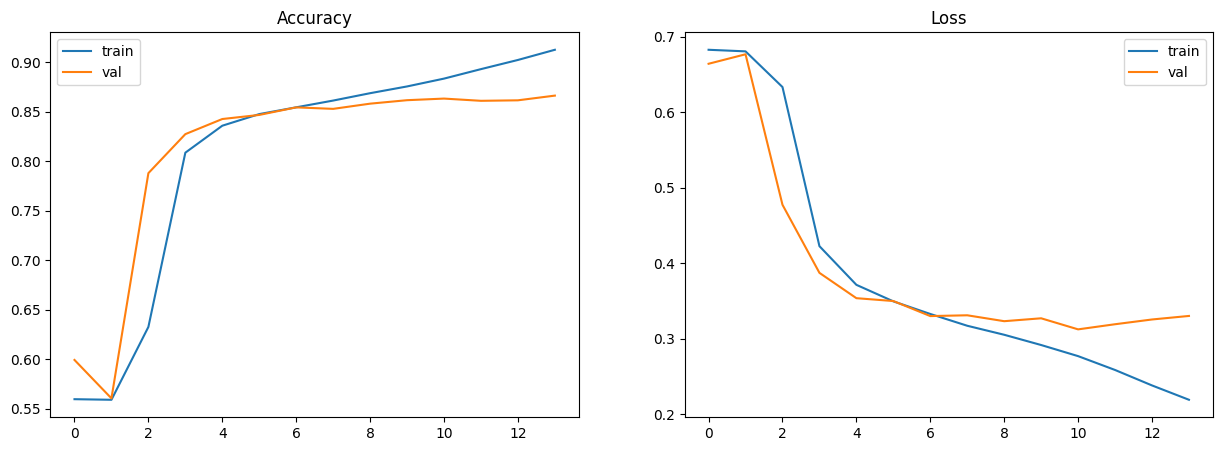

In [83]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Accuracy")
plt.legend(['train', 'val'])
plt.subplot(1,2,2)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Loss")
plt.legend(['train', 'val'])
plt.show()

### Test

In [84]:
y_test2 = encoding(y_test)
X_test2 = np.array(list(map(new_embedding, X_test)))

In [85]:
# test
eval_result = model.evaluate(X_test2, y_test2)
print(f"Loss: {eval_result[0]:.3f} \nAccuracy: {eval_result[1]:.3f}")

prediceted_labels = np.around(model.predict(X_test2))
preciscio = precision_score(y_test2, prediceted_labels)
recall = recall_score(y_test2, prediceted_labels)
print(f"Precision: {preciscio:.3f} \nRecall: {recall:.3f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8643 - loss: 0.3124
Loss: 0.312 
Accuracy: 0.866
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Precision: 0.857 
Recall: 0.881



In [86]:
sample_text = "This is a terrible movie"
sample_text = np.array(new_embedding(sample_text))
sample_text = np.reshape(sample_text, (1, sample_text.shape[0], sample_text.shape[1]))
prediction = model.predict(sample_text)
prediction = np.int32(np.around(prediction))[0][0]
all_categories[prediction]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


'Negative'

### Try train the model with Embedding layer

In [87]:
def another_tokenizer(x_train, max_words = 1000, max_len = 100):
    tkn = Tokenizer(num_words=max_words)
    tkn.fit_on_texts(x_train)
    seq = tkn.texts_to_sequences(x_train)

    padded_docs = pad_sequences(seq, padding = 'pre', maxlen= max_len)
    return padded_docs


X2 = another_tokenizer(X_train, max_len=200)

In [88]:
X2.shape

(40000, 200)

In [94]:
model2 = Sequential()
model2.add(Embedding(input_dim=1000, output_dim=100))
model2.add(LSTM(256))
# model2.add(Dropout(0.1))
model2.add(Dense(1, activation="sigmoid"))
# model.build(input_shape=(max_length_model, embedding_dim_model))
model2.build(input_shape=(1, max_length_model))
model2.compile(optimizer='nadam', loss='binary_crossentropy', metrics=["accuracy"])
print(model2.summary())

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (1, 200, 100)          │       100,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (1, 256)               │       365,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (1, 1)                 │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 465,825 (1.78 MB)

 Trainable params: 465,825 (1.78 MB)

 Non-trainable params: 0 (0.00 B)

None


In [95]:
early_stopping = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0,
)
history=model2.fit(X2, y, epochs=30, batch_size=128, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.6758 - loss: 0.5942 - val_accuracy: 0.8413 - val_loss: 0.3610
Epoch 2/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.8556 - loss: 0.3453 - val_accuracy: 0.8586 - val_loss: 0.3263
Epoch 3/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.8713 - loss: 0.3099 - val_accuracy: 0.8572 - val_loss: 0.3231
Epoch 4/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.8786 - loss: 0.2914 - val_accuracy: 0.8595 - val_loss: 0.3176
Epoch 5/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.8879 - loss: 0.2734 - val_accuracy: 0.8677 - val_loss: 0.3049
Epoch 6/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.8928 - loss: 0.2603 - val_accuracy: 0.8691 - val_loss: 0.3032
Epoch 7/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.9067 - loss: 0.2351 - val_accuracy: 0.8709 - val_loss: 0.3012
Epoch 8/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.9098 - loss: 0.2272 - val_accu

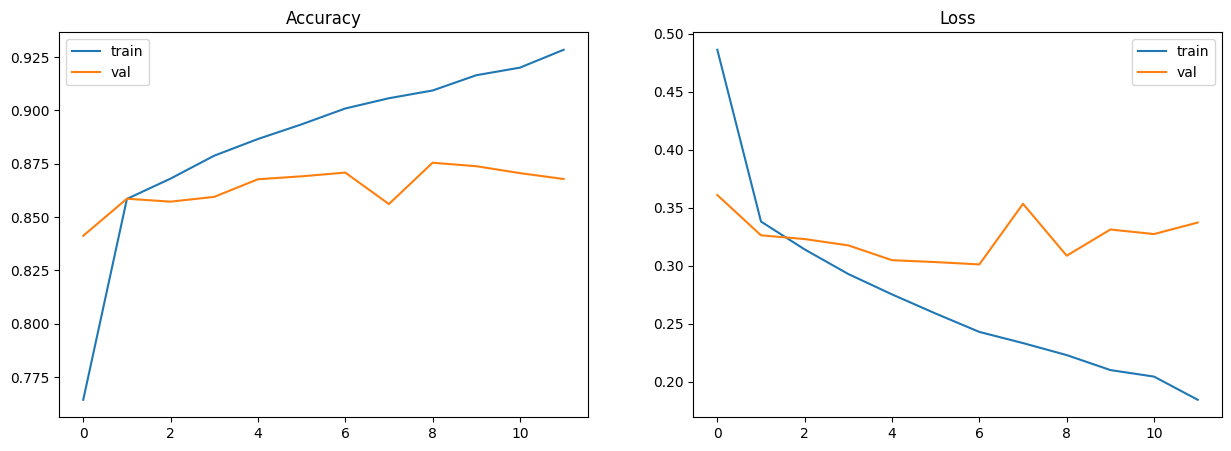

In [96]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Accuracy")
plt.legend(['train', 'val'])
plt.subplot(1,2,2)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Loss")
plt.legend(['train', 'val'])
plt.show()

In [92]:
# test
X_test_new2 = another_tokenizer(X_test, max_len=200)
y_test_new2 = encoding(y_test)

In [98]:
eval_result = model2.evaluate(X_test_new2, y_test_new2)
print(f"Loss: {eval_result[0]:.3f} \nAccuracy: {eval_result[1]:.3f}")

prediceted_labels = np.around(model2.predict(X_test_new2))
preciscio = precision_score(y_test_new2, prediceted_labels)
recall = recall_score(y_test_new2, prediceted_labels)
print(f"Precision: {preciscio:.3f} \nRecall: {recall:.3f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5489 - loss: 0.9647
Loss: 0.968 
Accuracy: 0.548
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Precision: 0.560 
Recall: 0.479
